In [1]:
import os
import pandas as pd
import sys
import json
from google.protobuf.json_format import Parse

sys.path.insert(0, 'compiled_protobufs')
from taskmap_pb2 import TaskMap

qrels_folder = os.path.join(os.getcwd(), 'measurements', 'judgments')
run_cooking_folder = os.path.join(os.getcwd(), 'measurements', 'cooking', 'run_files')
# run_diy_folder = os.path.join(os.getcwd(), 'measurements', 'diy', 'run_files')
cooking_runs = os.listdir(run_cooking_folder)
cooking_qrels = os.path.join(qrels_folder, "cooking.qrels")

queries = {
    "COOKING" : pd.read_csv('queries/cooking.csv'),
    "DIY": pd.read_csv('queries/diy.csv'),
}


In [6]:
from results_helper import get_all_metrics, get_all_metrics_searcher

path = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/all-metrics"

get_all_metrics(run_cooking_folder, cooking_qrels, path, with_t5=True)
# get_all_metrics_searcher(run_cooking_folder, cooking_qrels, path, s_name="marqo")

,R@20,Judged@10,nDCG@5,P@10,P@3,R@50,Judged@50,AP,P@5,Judged@20,nDCG@10,R@10,nDCG@3
tct-colbertv2+t5,0.282098,0.998,0.765028,0.817,0.873333,0.373775,0.3992,0.301700,0.856,0.7100,0.736549,0.197923,0.787039
ance+t5,0.266853,0.999,0.774191,0.816,0.880000,0.334201,0.3628,0.273348,0.854,0.6845,0.734727,0.198691,0.799944
bm25+rm3+t5,0.223626,0.896,0.615683,0.654,0.756667,0.285469,0.3766,0.214447,0.720,0.6450,0.566427,0.166328,0.648715
bm25+t5,0.238344,0.937,0.632498,0.687,0.780000,0.295946,0.3936,0.223072,0.732,0.6710,0.594362,0.173922,0.665810
hybrid-tct-bm25+rm3+t5,0.291808,0.902,0.725710,0.745,0.856667,0.435664,0.5316,0.334786,0.822,0.7605,0.674380,0.185317,0.756173
marqo+t5,0.249821,1.000,0.694586,0.777,0.806667,0.324356,0.4090,0.249353,0.810,0.6835,0.672133,0.184367,0.706732


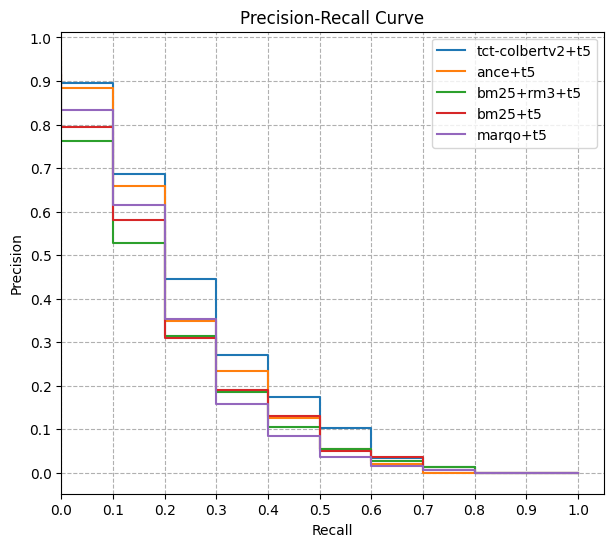

In [11]:
from results_helper import get_precision_recall_graph

get_precision_recall_graph(run_cooking_folder, cooking_qrels, with_t5 = True)

In [19]:
from results_helper import get_metrics, get_raw_query
from ir_measures import *  

queries = pd.read_csv("/home/ubuntu/task-search-quality/queries/cooking.csv")  

t5_vals = [False, True]
for t5 in t5_vals:
    ap_vals = get_metrics(run_cooking_folder, cooking_qrels, AP, t5)
    recall_vals = get_metrics(run_cooking_folder, cooking_qrels, Recall@50, t5)
    ndcg_vals = get_metrics(run_cooking_folder, cooking_qrels, nDCG@10, t5)
    ndcg_vals3 = get_metrics(run_cooking_folder, cooking_qrels, nDCG@3, t5)
    ndcg_vals5 = get_metrics(run_cooking_folder, cooking_qrels, nDCG@5, t5)
    

    results = {}
    results["COOKING"] = {
        "MAP": ap_vals,
        "Recall@50": recall_vals,
        "Ndgc@10": ndcg_vals,
        "Ndgc@3": ndcg_vals3,
        "Ndgc@5": ndcg_vals5,
    }

    analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis"
    
    if t5:
        analysis_folder += "/t5-results"
    else:
        analysis_folder += "/non-t5-results"
    if not os.path.exists(analysis_folder):
        os.mkdir(analysis_folder)

    for metric, df in results["COOKING"].items():
        pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()
        pivoted_df["query"] = pivoted_df.apply(lambda x: get_raw_query(x, queries), axis=1)
        pivoted_df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)

pivoted_df.head()

model,query_id,TCT-ColBERTv2+t5,ance+t5,bm25+rm3+t5,bm25+t5,marqo+t5,query
0,query-0,0.851630,0.851630,0.773468,0.773468,0.646382,how to spatchcock a turkey
1,query-1,0.330420,0.701224,0.500000,0.458609,0.565603,I want an easy to make dessert for christmas
2,query-10,0.691783,0.808217,0.684352,0.795761,0.650393,recommend some asian street foods
3,query-11,1.000000,0.868795,0.361363,0.084790,0.339160,dinners by batali
4,query-12,0.934397,0.934397,0.065603,0.084790,0.776573,traditional japanese soup


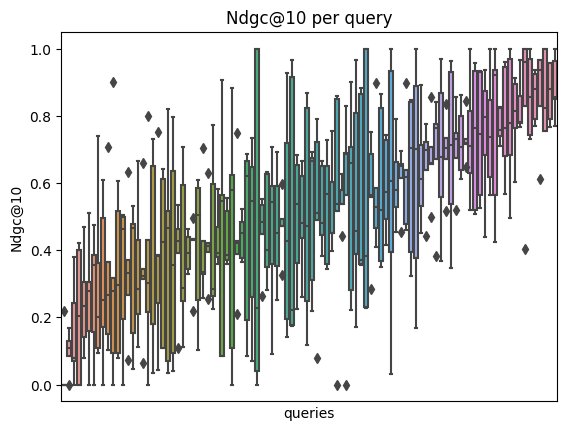

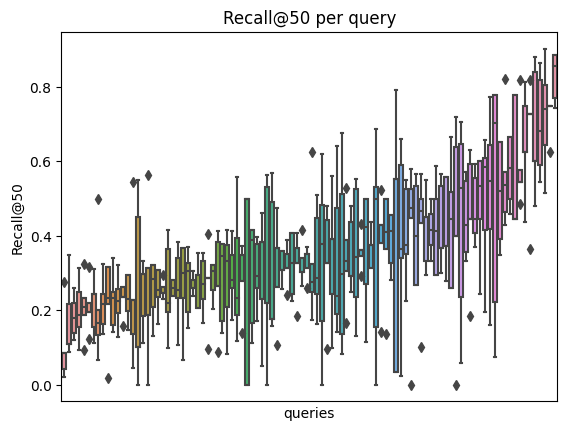

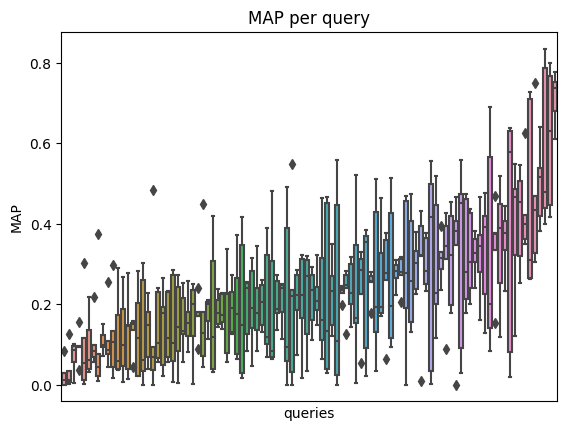

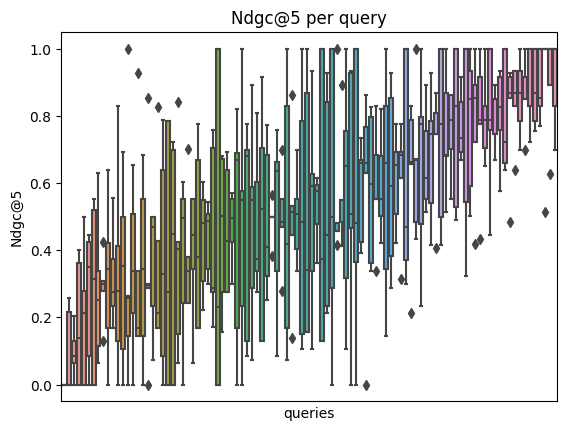

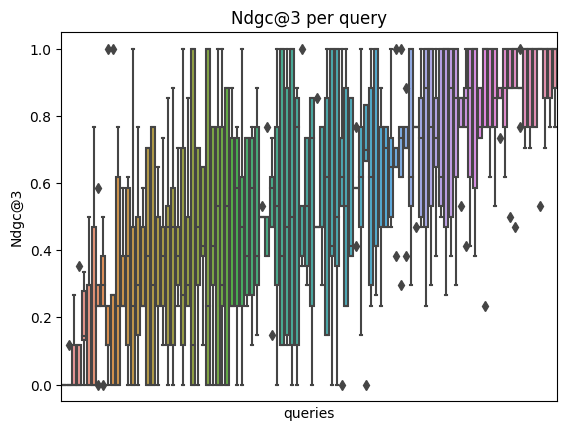

,query_id,TCT-ColBERTv2,ance,bm25,bm25+rm3,marqo,query,mean
81,query-82,1.000000,1.000000,1.000000,0.765361,0.765361,slow-cooked fall-off-the-bone ribs,0.906144
79,query-80,1.000000,1.000000,1.000000,1.000000,0.530721,i want a crispy burrito,0.906144
7,query-15,1.000000,0.851959,0.703918,1.000000,1.000000,mexican fiesta recipees,0.911175
16,query-23,1.000000,1.000000,0.851959,1.000000,0.765361,how to make overnight oats,0.923464
58,query-61,0.765361,0.882680,1.000000,1.000000,1.000000,suggestions for a summer grill recipe,0.929608


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

for file in files:
    
    # print(file)
    filepath = os.path.join(analysis_folder, file)
    df = pd.read_csv(filepath) # index_col="query_id"
    df["mean"] = df.mean(axis=1, numeric_only=True)
    df = df.sort_values(by=["mean"], ascending=True)
    # print(df.columns)
    df_T = df[df.columns[1:-2]].T
    # print(df_T)
    sns.boxplot(data=df_T)
    
    y_label = file.split(".")[0]
    
    plt.title(f"{y_label} per query")
    plt.ylabel(y_label)
    plt.xlabel("queries")
    plt.xticks([])
    plt.show()

df.tail()

Ndgc@3.csv
TCT-ColBERTv2    0.102530
ance             0.137199
bm25             0.103175
bm25+rm3         0.028964
marqo            0.000000
mean             0.074374
dtype: float64
MAP.csv
TCT-ColBERTv2    0.057013
ance             0.040558
bm25             0.080885
bm25+rm3         0.058259
marqo            0.085506
mean             0.064444
dtype: float64
Ndgc@5.csv
TCT-ColBERTv2    0.197770
ance             0.220936
bm25             0.111232
bm25+rm3         0.013121
marqo            0.027727
mean             0.114157
dtype: float64
Ndgc@10.csv
TCT-ColBERTv2    0.126526
ance             0.141749
bm25             0.170853
bm25+rm3         0.137957
marqo            0.170527
mean             0.149523
dtype: float64
Ndgc@3.csv
TCT-ColBERTv2    0.133945
ance             0.368599
bm25             0.131196
bm25+rm3         0.126214
marqo            0.082124
mean             0.168416
dtype: float64
MAP.csv
TCT-ColBERTv2    0.109888
ance             0.081383
bm25             0.073651
bm25+r

/tmp/ipykernel_7086/1625237420.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


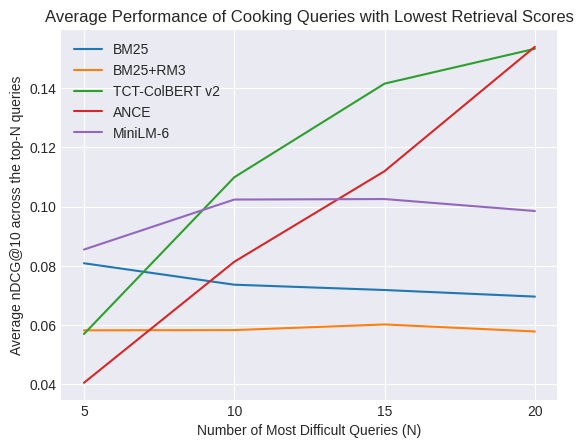

/tmp/ipykernel_7086/1625237420.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


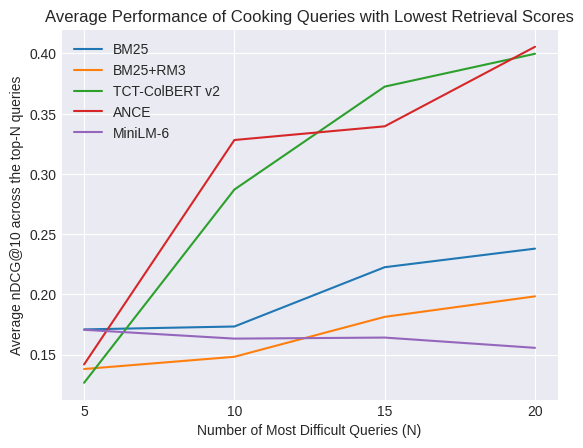

/tmp/ipykernel_7086/1625237420.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


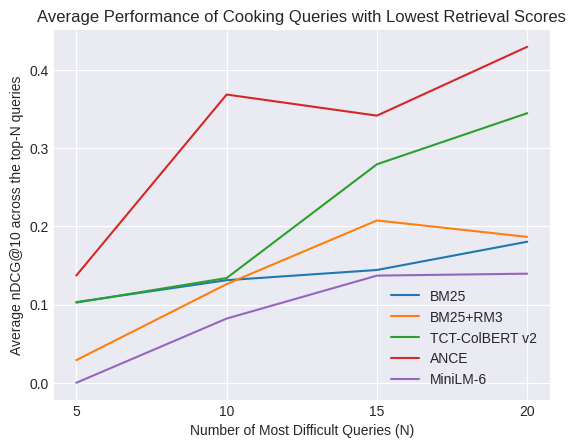

/tmp/ipykernel_7086/1625237420.py:50: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


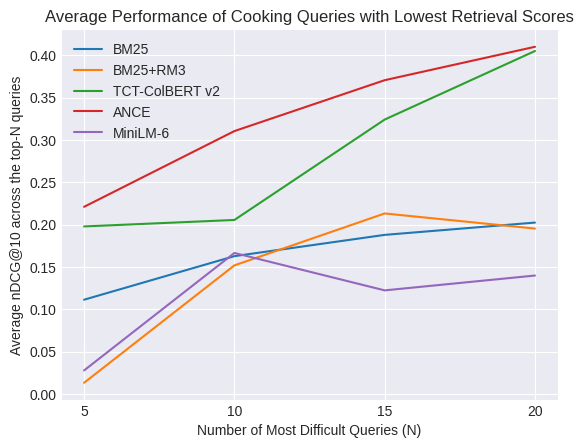

In [29]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

thresholds = [5,10, 15,20]

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        hardest_10 = df.head(threshold)
        hardest_10 = hardest_10.drop(columns = ["query_id", "query"])
        hardest_10.mean()
        print(file)
        print(hardest_10.mean())
        results[(threshold, file.split('.')[0])] = hardest_10.mean()


res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "BM25": vals["bm25"],       
            "BM25+RM3": vals["bm25+rm3"],      
            "TCT-ColBERT v2": vals["TCT-ColBERTv2"], 
            "ANCE": vals["ance"],   
            "MiniLM-6": vals["marqo"],      
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

print(df_hardest["metric"].unique())

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel("Average nDCG@10 across the top-N queries")
    plt.xlabel("Number of Most Difficult Queries (N)")
    # set the title
    plt.title("Average Performance of Cooking Queries with Lowest Retrieval Scores")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()

/tmp/ipykernel_7086/3946603412.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


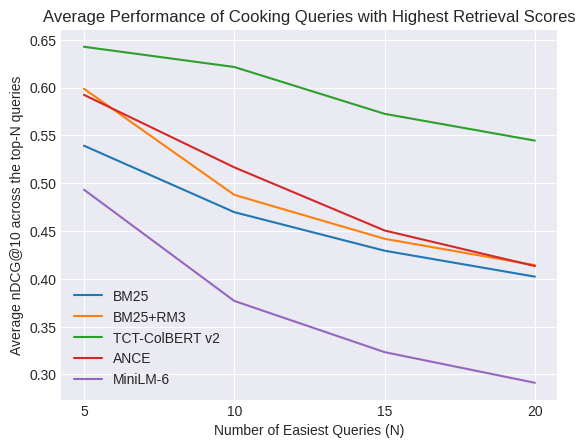

/tmp/ipykernel_7086/3946603412.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


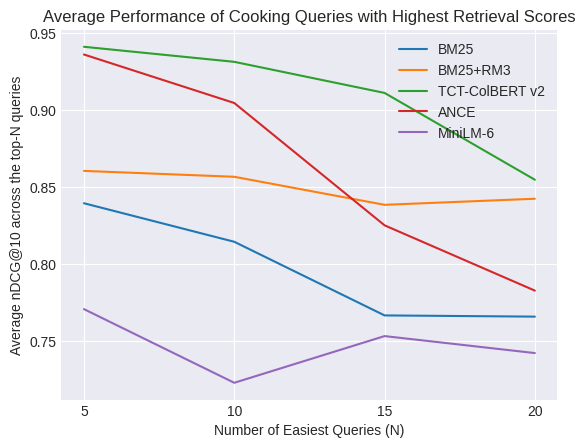

/tmp/ipykernel_7086/3946603412.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


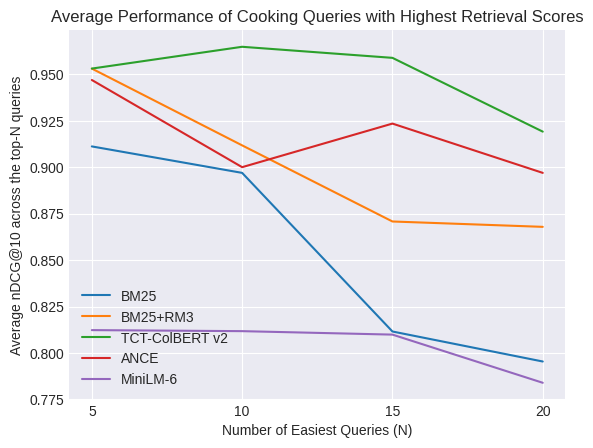

/tmp/ipykernel_7086/3946603412.py:48: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


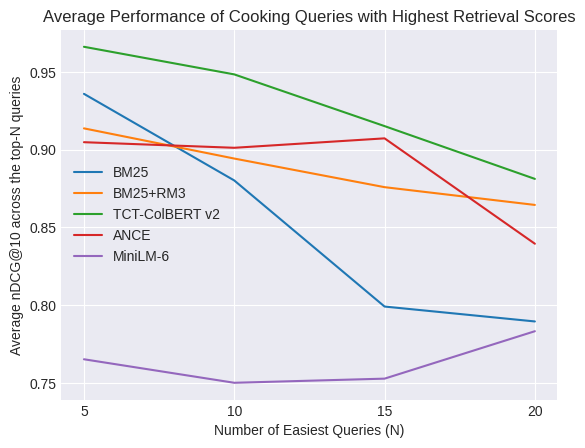

In [28]:
analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/non-t5-results"

files = os.listdir(analysis_folder)

results = {}

# thresholds = range(1,21)
thresholds = [5,10,15,20]

for threshold in thresholds:
    for file in files:
        
        # print(file)
        if "Recall" in file:
            continue
        filepath = os.path.join(analysis_folder, file)
        df = pd.read_csv(filepath) # index_col="query_id"
        df["mean"] = df.mean(axis=1, numeric_only=True)
        df = df.sort_values(by=["mean"], ascending=True)
        easiest = df.tail(threshold)
        easiest = easiest.drop(columns = ["query_id", "query"])
        easiest.mean()
        # print(file)
        # print(easiest.mean())
        results[(threshold, file.split('.')[0])] = easiest.mean()

res = []
for threshold, vals in results.items():
        res.append({
            "metric": threshold[1],
            "threshold": threshold[0],
            "BM25": vals["bm25"],       
            "BM25+RM3": vals["bm25+rm3"],      
            "TCT-ColBERT v2": vals["TCT-ColBERTv2"], 
            "ANCE": vals["ance"],   
            "MiniLM-6": vals["marqo"],          
        })
df_hardest = pd.DataFrame(res)
df_hardest.sort_values(by="metric", inplace=True)
df_hardest.head()


import matplotlib.pyplot as plt

for metric in df_hardest["metric"].unique():
    df = df_hardest[df_hardest["metric"] == metric]
    # set the plot style
    plt.style.use('seaborn-darkgrid')
    # plot the line plot
    for model in df.columns[2:]:
        plt.plot(df["threshold"], df[model], label=model)

    plt.xticks([5, 10, 15, 20])
    plt.ylabel("Average nDCG@10 across the top-N queries")
    plt.xlabel("Number of Easiest Queries (N)")
    # set the title
    plt.title("Average Performance of Cooking Queries with Highest Retrieval Scores")
    # add the legend
    plt.legend()
    # show the plot
    plt.show()

### Analysis of different task representations

In [2]:
from ir_measures import *

path_marqo_runs = "/home/ubuntu/task-search-quality/measurements/cooking/run_files/marqo-filters"
diy_qrels = "/home/ubuntu/task-search-quality/measurements/judgments/cooking.qrels"


metrics = [nDCG@3, nDCG@10, Precision@3, Precision@10, Recall@50, Judged@10, MAP]

In [4]:
from results_helper import get_all_metrics

path = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters"

get_all_metrics(path_marqo_runs, diy_qrels, path, with_t5=None, metrics=metrics)

,P@3,nDCG@3,R@50,Judged@10,P@10,AP,nDCG@10
requirements,0.356667,0.306369,0.055661,0.509,0.186,0.032485,0.205483
steps-requirements,0.453333,0.376621,0.099457,0.612,0.279,0.050835,0.275714
steps,0.470000,0.390503,0.083180,0.558,0.267,0.047082,0.272760
title-requirements,0.803333,0.719944,0.326699,0.725,0.619,0.226138,0.590781
title-steps-requirements,0.760000,0.682235,0.321650,0.774,0.619,0.224949,0.580752
title-steps,0.763333,0.686928,0.320266,0.772,0.620,0.224668,0.582328
title,0.806667,0.724637,0.321841,0.714,0.616,0.225062,0.590100
marqo,0.670000,0.561676,0.324356,0.998,0.643,0.204254,0.551265


In [5]:
"""Statistical Significance"""

import scipy
from ir_measures import *
from results_helper import get_metrics

metrics = [AP, nDCG@3, nDCG@10, P@3, P@10, R@50]

# def check_null_hyypothesis(run_diy_folder, diy_qrels, metric, )

ttest_results = {}
for metric in metrics:

    df = get_metrics(path_marqo_runs, diy_qrels, metric, t5 = None)
    print(path_marqo_runs)
    pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()

    print(pivoted_df.columns)
    baseline = pivoted_df["Title"]
    # pivoted_df
    compared_models = [m_name for m_name in pivoted_df.columns] 
    compared_models.remove('query_id')
    compared_models.remove('Title')

    results_for_metric = {}
    for model_name in compared_models:
        value_metrics = pivoted_df[model_name]
        statistic, pvalue = scipy.stats.ttest_rel(a = value_metrics, b = baseline)
        results_for_metric[model_name] = pvalue
        # print(m_name, statistic, pvalue)
    ttest_results[metric] = results_for_metric


ttest_pd = pd.DataFrame(ttest_results)


/home/ubuntu/task-search-quality/measurements/cooking/run_files/marqo-filters
Index(['query_id', 'Requirements', 'Steps', 'Steps-Requirements', 'Title',
       'Title-Requirements', 'Title-Steps', 'Title-Steps-Requirements',
       'marqo'],
      dtype='object', name='model')
/home/ubuntu/task-search-quality/measurements/cooking/run_files/marqo-filters
Index(['query_id', 'Requirements', 'Steps', 'Steps-Requirements', 'Title',
       'Title-Requirements', 'Title-Steps', 'Title-Steps-Requirements',
       'marqo'],
      dtype='object', name='model')
/home/ubuntu/task-search-quality/measurements/cooking/run_files/marqo-filters
Index(['query_id', 'Requirements', 'Steps', 'Steps-Requirements', 'Title',
       'Title-Requirements', 'Title-Steps', 'Title-Steps-Requirements',
       'marqo'],
      dtype='object', name='model')
/home/ubuntu/task-search-quality/measurements/cooking/run_files/marqo-filters
Index(['query_id', 'Requirements', 'Steps', 'Steps-Requirements', 'Title',
       'Title

In [6]:
ttest_pd < 0.05

,AP,nDCG@3,nDCG@10,P@3,P@10,R@50
Requirements,True,True,True,True,True,True
Steps,True,True,True,True,True,True
Steps-Requirements,True,True,True,True,True,True
Title-Requirements,False,False,False,False,False,True
Title-Steps,False,True,False,True,False,False
Title-Steps-Requirements,False,True,False,True,False,False
marqo,False,True,False,True,False,False


In [17]:
from results_helper import get_metrics, get_raw_query
from ir_measures import *  

queries = pd.read_csv("/home/ubuntu/task-search-quality/queries/cooking.csv")  
diy_qrels = "/home/ubuntu/task-search-quality/measurements/judgments/cooking.qrels"

ap_vals = get_metrics(path_marqo_runs, diy_qrels, AP, t5=False)
ndcg_vals = get_metrics(path_marqo_runs, diy_qrels, nDCG@10, t5=False)



results = {}
results["DIY"] = {
    "Ndgc@10": ndcg_vals,
    "MAP": ap_vals,
}

analysis_folder = "/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters"


for metric, df in results["DIY"].items():
    pivoted_df = df.pivot(index='query_id', columns='model', values='metric_val').reset_index()
    pivoted_df["query"] = pivoted_df.apply(lambda x: get_raw_query(x, queries), axis=1)
    pivoted_df.to_csv(os.path.join(analysis_folder, metric+".csv"), index=False)

pivoted_df.head()


model,query_id,Requirements,Steps,Steps-Requirements,Title,Title-Requirements,Title-Steps,Title-Steps-Requirements,query
0,query-0,0.078161,0.147989,0.147989,0.217388,0.227249,0.261258,0.261258,how to spatchcock a turkey
1,query-1,0.000000,0.086957,0.086957,0.253476,0.253476,0.311795,0.311795,I want an easy to make dessert for christmas
2,query-10,0.063393,0.067259,0.067259,0.084184,0.084184,0.125378,0.125378,recommend some asian street foods
3,query-11,0.000000,0.042605,0.042605,0.021368,0.021368,0.024115,0.024115,dinners by batali
4,query-12,0.055556,0.058291,0.092328,0.572072,0.572072,0.572072,0.572072,traditional japanese soup


['/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters/Ndgc@10.csv', '/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters/MAP.csv']
Index(['query_id', 'Requirements', 'Steps', 'Steps-Requirements', 'Title',
       'Title-Requirements', 'Title-Steps', 'Title-Steps-Requirements',
       'query'],
      dtype='object')


/tmp/ipykernel_14933/2157294973.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


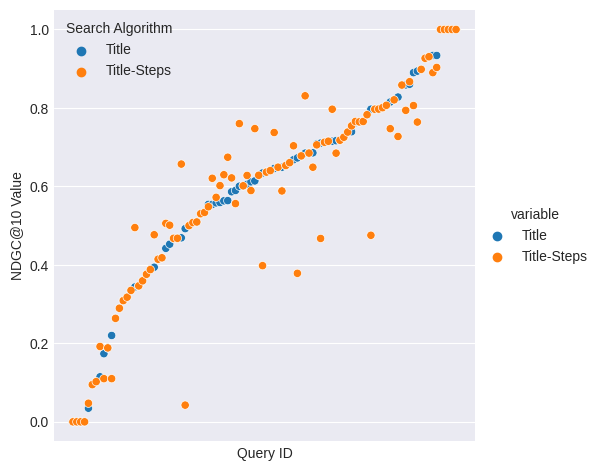

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

paths = []
paths.append("/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters/Ndgc@10.csv")
paths.append("/home/ubuntu/task-search-quality/measurements/cooking/analysis/marqo-filters/MAP.csv")
print(paths)
df = pd.read_csv(paths[0])
# df2 = pd.read_csv(paths[1])

print(df.columns)

df.sort_values(by=["Title"], inplace=True)

# Plot the dots for each column using relplot
sns.relplot(x='query_id', y='value', kind='scatter', hue='variable', data=pd.melt(df[["query_id", "Title", "Title-Steps"]], id_vars='query_id'))

# Add labels to the x and y axes
plt.xlabel("Query ID")
plt.ylabel("NDGC@10 Value")
plt.xticks([])
plt.style.use('seaborn-darkgrid')
plt.legend(title="Search Algorithm")
plt.show()

In [22]:
df["t vs t+s"] = df["Title"] - df["Title-Steps"]
df.sort_values(by=["t vs t+s"], inplace=True)
df.head()

,query_id,Requirements,Steps,Steps-Requirements,Title,Title-Requirements,Title-Steps,Title-Steps-Requirements,query,t vs t+s
69,query-71,0.415281,0.496314,0.593342,0.469000,0.563788,0.656963,0.678869,meals pair with wine,-0.187963
2,query-10,0.538886,0.453743,0.453743,0.600470,0.600470,0.760079,0.760079,recommend some asian street foods,-0.159609
66,query-69,0.554143,0.563788,0.563788,0.343697,0.343697,0.495094,0.495094,plant based food recipes,-0.151397
64,query-67,0.538886,0.469000,0.469000,0.684758,0.684758,0.830926,0.830926,fast and easy picnic foods,-0.146168
43,query-48,0.538886,0.598392,0.598392,0.614068,0.614068,0.747320,0.747320,how to make a refreshing sweet smoothie,-0.133252


In [23]:
# Title better
df.tail()

,query_id,Requirements,Steps,Steps-Requirements,Title,Title-Requirements,Title-Steps,Title-Steps-Requirements,query,t vs t+s
19,query-26,0.503943,0.359409,0.359409,0.634287,0.747729,0.398041,0.398041,how to prepare spicy oysters,0.236245
99,query-99,0.000000,0.000000,0.000000,0.710477,0.710477,0.467379,0.467379,make chicken soup with homemade broth,0.243098
32,query-38,0.368376,0.069431,0.069431,0.672614,0.672614,0.378501,0.378501,how can i make one pot ramen,0.294113
35,query-40,0.000000,0.233139,0.233139,0.796761,0.793584,0.475450,0.475450,how to make salty brownies,0.321311
20,query-27,0.085143,0.042572,0.042572,0.492381,0.261808,0.042572,0.042572,how to quickly make baby food,0.449810


<BarContainer object of 14 artists>

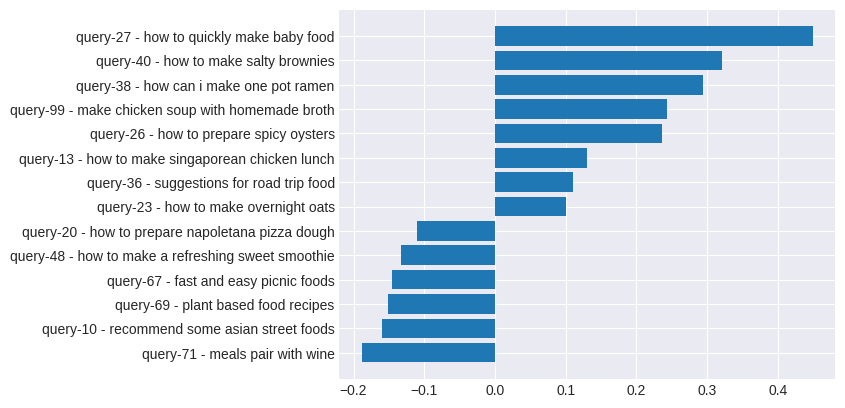

In [26]:
threshold = 0.1
df = df[(df['t vs t+s'] < -0.1) | (df['t vs t+s'] > 0.1)]


plt.barh(df['query_id'] + ' - '+ df['query'], df['t vs t+s'])
plt.title("nDCG@10 difference between Title and Steps vs Title")